In [1]:
from p_drought_indices.functions.function_clns import load_config, cut_file, subsetting_pipeline
from p_drought_indices.functions.ndvi_functions import downsample, clean_ndvi, compute_ndvi, clean_outliers
from p_drought_indices.vegetation.cloudmask_cleaning import extract_apply_cloudmask, plot_cloud_correction, compute_difference, compute_correlation
import xarray as xr 
import pandas as pd
import yaml
from datetime import datetime, timedelta
import shutil
#from shapely.geometry import Polygon, mapping
#import geopandas as gpd
import matplotlib.pyplot as plt
from glob import glob
import os
#import datetime as datetime
import time
import numpy as np
import re
from p_drought_indices.vegetation.NDVI_indices import compute_svi, compute_vci
from p_drought_indices.analysis.metrics_table import MetricTable
from p_drought_indices.functions.function_clns import open_xarray_dataset

CONFIG_PATH = r"../config.yaml"


/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "/media/BIFROST/N2/Riccardo/MSG/msg_data/batch_3"

In [3]:
from p_drought_indices.eumetsat_data_collection.pipeline import pipeline_ndvi
import geopandas as gpd

In [4]:
list_files = [os.path.join(path,f) for f in os.listdir(path) if f.endswith(".nc")]

countries = ["Kenya", "Somalia", "Ethiopia"]

CONFIG_PATH = r"../config.yaml"
config = load_config(CONFIG_PATH)
shapefile_path = config['SHAPE']['africa']
gdf = gpd.read_file(shapefile_path)
subset = gdf[gdf.ADM0_NAME.isin(countries)]

In [6]:
for file in list_files:
    name = file.split("/")[-1]
    ds = xr.open_dataset(file)
    ds_new = pipeline_ndvi(ds, subset)
    ds_new.to_netcdf(os.path.join(path,"processed",name))
    ds_new.close()

In [7]:
config = load_config(CONFIG_PATH)
product_directory =  config['NDVI']['ndvi_path']
var = 'vci'
countries=["Ethiopia","Kenya","Somalia"]
table_metrics = pd.DataFrame()
for product_dir in [config['SPI']['IMERG']['path'], config['SPI']['GPCC']['path'], config['SPI']['CHIRPS']['path'], config['SPI']['ERA5']['path']]:
    for late in [30, 60, 90, 180]:
        var_target = f"spi_gamma_{late}"
        spi = MetricTable(product_directory, product_dir, var, var_target, CONFIG_PATH, countries=countries)
        spi.compute_metrics_soil(freq="daily")
        table_df = spi.df_cover
        table_metrics = pd.concat([table_metrics, table_df],ignore_index=True)
table_metrics.to_csv(r'../data/spi_vci_daily.csv')


In [2]:
from dask.distributed import Client
import dask

client = Client(n_workers=8, threads_per_worker=2)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 182.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39795,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 182.00 GiB
Comm: tcp://127.0.0.1:43681,Total threads: 2
Dashboard: http://127.0.0.1:34503/status,Memory: 22.75 GiB
Nanny: tcp://127.0.0.1:34825,


In [1]:
import xarray as xr
import os

from p_drought_indices.functions.function_clns import load_config
CONFIG_PATH = "../config.yaml"
config = load_config(CONFIG_PATH)
ds = xr.open_dataset(os.path.join(config['NDVI']['ndvi_path'], 'ndvi_no_out.nc'))

In [2]:
ds = ds.assign(dayofyear = ds["time"].dt.dayofyear)

In [12]:
class dfDay:
    def __init__(self, ds:xr.Dataset) -> None:
        self.dataset = ds
  
    def get_day(self, day:int):
        df = self.dataset.where(self.dataset["dayofyear"]==day, drop=True)["ndvi"].to_dataframe()
        self.df = self._clen_df(df)
        self.df_name = f"data_{day}"
    
    def _clen_df(self, df):
        df.reset_index(drop=False, inplace=True)
        df = df.dropna(subset=["ndvi"])
        df = df.drop(columns={"spatial_ref"})
        return df.reset_index(drop=True)

In [82]:
day_obj = dfDay(ds= ds)

day_obj.get_day(day = 1)

df_list = []
for day in range(1,367):
    day_obj.get_day(day)
    locals()[day_obj.df_name] = day_obj.df
    df_list.append(locals()[day_obj.df_name]["ndvi"])

In [83]:
import pandas as pd

def get_dates(gap_year=False):
    if gap_year==False:
        return pd.date_range("01-Jan-2021", "31-Dec-2021", freq="D").to_series().dt.strftime('%d-%b').values
    else:
        return pd.date_range("01-Jan-2020", "31-Dec-2020", freq="D").to_series().dt.strftime('%d-%b').values

In [84]:
list_dates = get_dates(gap_year=True)

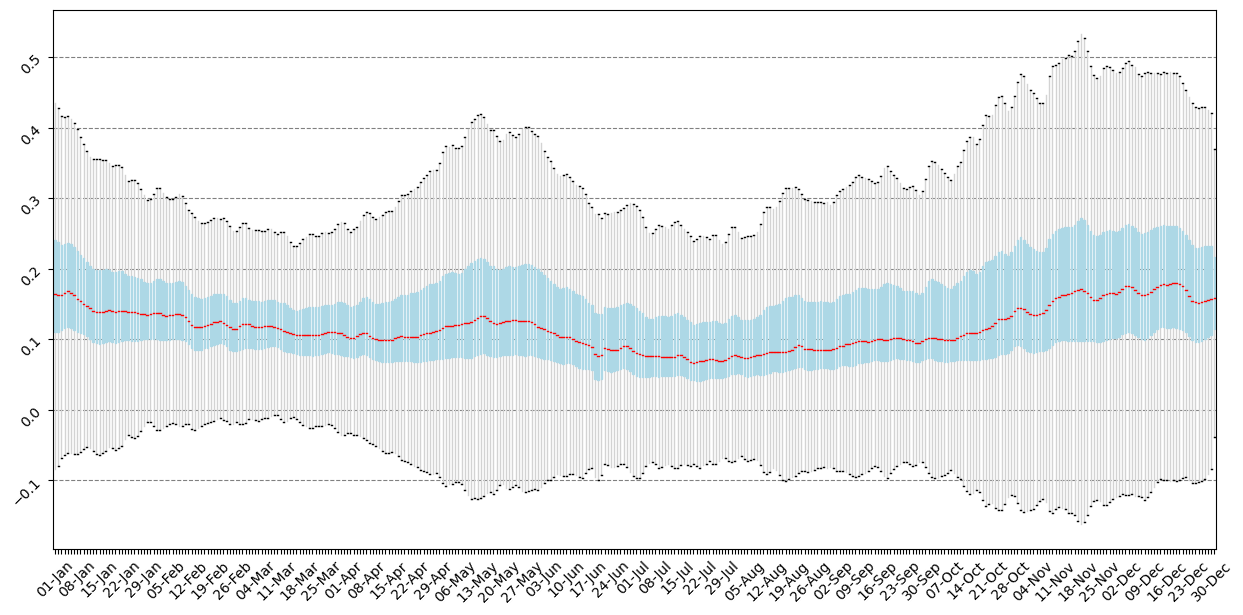

In [92]:
import matplotlib.pyplot as plt
import numpy as np
 
fig, ax = plt.subplots(figsize =(15, 7))
 
# Creating plot
boxplot = ax.boxplot(df_list, showfliers=False, patch_artist=True, labels=list_dates)
n=7
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
n= 10
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_gridlines()) if i % n != 0]

ax.tick_params(labelrotation=45)
for median in boxplot['medians']:
    median.set_color('red')
    
for box in boxplot["boxes"]:
    box.set_color("lightblue")

for whisk in boxplot["whiskers"]:
    whisk.set_color("lightgrey")
 
# show plot
plt.show()

In [119]:
year=None

type(year)

NoneType

In [120]:
import calendar
import matplotlib.pyplot as plt
import numpy as np
from typing import Union

ds_subset = ds.sel(time=ds.time.dt.year.isin([2010,2011]))

def box_plot_year(ds, year:Union[None, int,list]=None):
    if year==None:
        days = 366
    elif type(year)==list:
        if True in [True for y in year if calendar.isleap(y)]:
            days=366
        else: days = 365
    else:
        days=366 if calendar.isleap(year) else 365

    day_obj = dfDay(ds)
    df_list = []
    for day in range(1,days+1):
        day_obj.get_day(day)
        locals()[day_obj.df_name] = day_obj.df
        df_list.append(locals()[day_obj.df_name]["ndvi"])

    bool_days = False if days==365 else True
    list_dates = get_dates(gap_year=bool_days)
 
    fig, ax = plt.subplots(figsize =(15, 7))
    
    # Creating plot
    boxplot = ax.boxplot(df_list, showfliers=False, patch_artist=True, labels=list_dates)
    n=7
    ax.set_axisbelow(True)
    ax.yaxis.grid(color='gray', linestyle='dashed')
    [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]
    n= 10
    [l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_gridlines()) if i % n != 0]

    ax.tick_params(labelrotation=45)
    for median in boxplot['medians']:
        median.set_color('red')

    for box in boxplot["boxes"]:
        box.set_color("lightblue")

    for whisk in boxplot["whiskers"]:
        whisk.set_color("lightgrey")
    
    # show plot
    plt.show()


In [121]:
box_plot_year(ds, year=None)

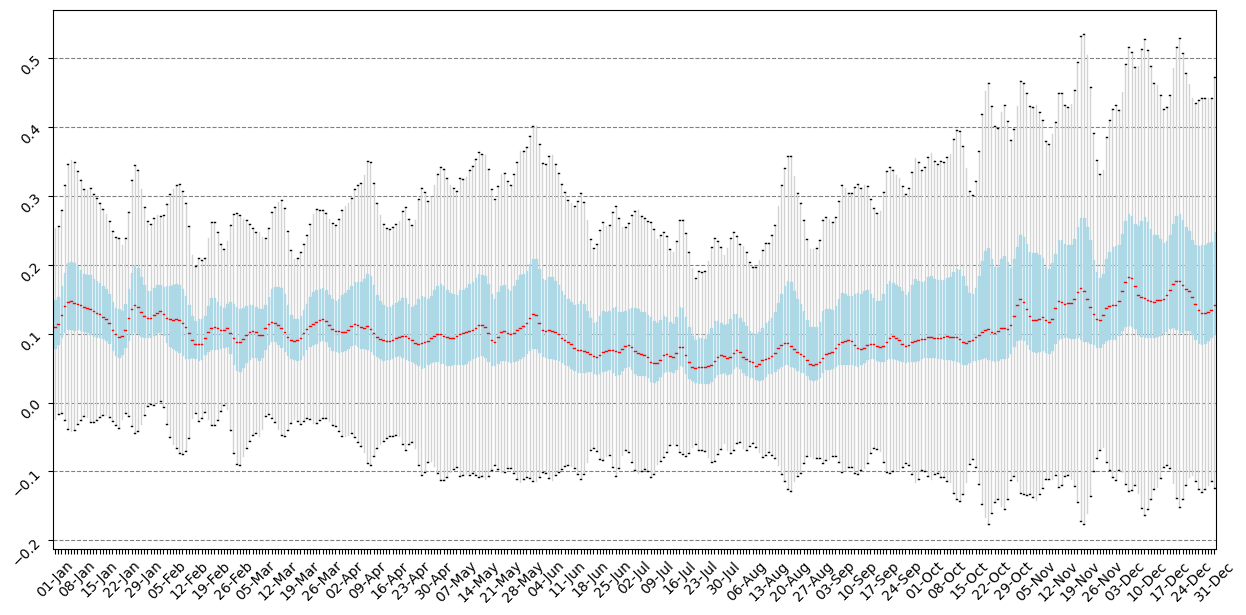

In [111]:
box_plot_year(ds_subset, [2010,2011])

### Processing and smoothing NDVI

In [3]:
chunks = {"time": "500MB"}
CONFIG_PATH = r"../config.yaml"
config = load_config(CONFIG_PATH)
ndvi_dir = config['NDVI']['ndvi_prep']
ds = xr.open_dataset(os.path.join(ndvi_dir, "final_ndvi.nc"), chunks=chunks)

In [3]:
def drop_coords(ds):
    ds = ds.drop(['crs','channel_1', 'channel_2'])
    return ds.reset_coords(drop=True)

def get_ndvi(ds):
    ds.attrs = {}
    ds=  ds[["lat","lon","time","ndvi"]]
    return ds.reset_coords(drop=True)

chunks = {"time": "500MB"}
CONFIG_PATH = r"../config.yaml"
config = load_config(CONFIG_PATH)
ndvi_dir = config['NDVI']['ndvi_prep']
list_files = [os.path.join(ndvi_dir,file) for file in os.listdir(ndvi_dir) if re.match('HRSEVIRI_20\d+.*', file)]

In [4]:
from p_drought_indices.functions.function_clns import open_xarray_dataset
from tqdm.auto import tqdm
def prepare(ds):
        ds.rio.write_crs("epsg:4326", inplace=True)
        ds.rio.set_spatial_dims(x_dim='lon', y_dim='lat', inplace=True)
        return ds

def convert_to_raster(list_files:list, target_darray:xr.DataArray):
    for path in tqdm(list_files, desc="Files"):
        ds = xr.open_dataset(path)
        ds = prepare(ds)
        ds_ndvi = ds["ndvi"].rio.reproject_match(target_darray).rename({"x":"lon","y":"lat"})
        ds_ndvi = ds_ndvi.to_dataset()
        channel_1 = ds["channel_1"].rio.reproject_match(target_darray).rename({"x":"lon","y":"lat"})
        channel_2 = ds["channel_2"].rio.reproject_match(target_darray).rename({"x":"lon","y":"lat"})
        ds_ndvi = ds_ndvi.assign(channel_1 = channel_1, channel_2= channel_2)
        name = path.split("/")[-1]
        ds_ndvi.to_netcdf(os.path.join(ndvi_dir, "reprojected", name))

def concat_datasets(path_1, path_2):
    ds_1 = open_xarray_dataset(list_files_1)
    ds_2 = open_xarray_dataset(list_files_2)
    return xr.concat([ds_2, ds_1], dim="time")

new_dir = os.path.join(ndvi_dir,"new_process")
list_files_2 = [os.path.join(new_dir, f) for f in os.listdir(new_dir) if f.endswith(".nc")]
ds_2 = xr.open_dataset(list_files_2[0])

new_dir = os.path.join(ndvi_dir,"old_process")
list_files_1 = [os.path.join(new_dir, f) for f in os.listdir(new_dir) if f.endswith(".nc")]
ds_1 = xr.open_dataset(list_files_1[0])

#convert_to_raster(list_files_1, target_darray=prepare(ds_2)["ndvi"])


/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
new_dir = os.path.join(ndvi_dir,"reprojected")
list_files_3 = [os.path.join(new_dir, f) for f in os.listdir(new_dir) if f.endswith(".nc")]

ds = concat_datasets(list_files_3, list_files_2)

#ds.to_netcdf(os.path.join(ndvi_dir,"final_ndvi_new.nc"))

/media/BIFROST/N2/Riccardo/MSG/msg_data/batch_2/processed/old_process/HRSEVIRI_20050101T121200Z_20050101T121200Z_epct_aebcaaa6_FP.nc
paramapampam
/media/BIFROST/N2/Riccardo/MSG/msg_data/batch_2/processed/new_process/HRSEVIRI_20100312T122700Z_20100312T122700Z_epct_49c30686_FP.nc
paramapampam


/home/woden/anaconda3/envs/ric_gis2_py39/lib/python3.9/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [6]:
base_dir = 'nc_files/new/ndvi_mask.nc'
cl_df = xr.open_dataset(os.path.join(config['NDVI']['cloud_path'], base_dir), chunks={"time":"250MB"})
cl_df = cl_df.sel(time=slice(cl_df['time'].min(), '2020-12-31'))

ds_cl = prepare(cl_df)
ds_cl = ds_cl["cloud_mask"].rio.reproject_match(prepare(ds_2)["ndvi"]).rename({'y':'lat', 'x':'lon'})

In [ ]:
import geopandas as gpd
CONFIG_PATH = "../config.yaml"
config = load_config(CONFIG_PATH)
xr_df = clean_outliers(ds)

shapefile_path = config['SHAPE']['africa']
gdf = gpd.read_file(shapefile_path)
countries = ['Ethiopia','Kenya','Somalia']
subset = gdf[gdf.ADM0_NAME.isin(countries)]

ds_n = cut_file(xr_df, subset)
ds_cl = cut_file(ds_cl, subset)
mask_clouds, res_xr = extract_apply_cloudmask(ds_n, ds_cl)

### Loop to apply tablemetric for vci to each product 

In [ ]:
import seaborn as sns
def plot_data(data, metric, precp_idx, country, product):
    y = data[metric].loc[(data['precp_idx'] == precp_idx) & (data['country'] == country)\
        & (data['product'] == product)]

    #y.dropna().plot(kind='hist', bins=30, kde=True)
    sns.displot(y.dropna(), kde=True)
    plt.title(f"metric {metric} for {precp_idx} {product} in {country}")
    plt.show()

def group_plot(data, country, product):
    grouped = data.loc[(data['country'] == country)\
                & (data['product'] == product)]
    grouped = grouped.groupby(['precp_idx'])
    fig, ax = plt.subplots()
    grouped.plot(kind='hist', y='far', ax=ax, legend=True)
    plt.show()

def plot_data_spi(data, metric, country, product):
    spi_list = table_metrics['precp_idx'].unique()
    fig, ax = plt.subplots(1,4)

    for i, spi in enumerate(spi_list):
        y = data[metric].loc[(data['country'] == country)\
            & (data['product'] == product)]
        y= y.dropna()

        sns.displot(y, kde=True)
    #plt.title(f"metric {metric} for {product} in {country}")
    #plt.show()

### Load data and plot 

In [ ]:
data = pd.read_csv(r'../data/spi_vci/spi_vci_daily.csv').iloc[:, 1:]

In [ ]:
metric ='pod' 
precp_idx= 'spi_gamma_180'
country='Ethiopia' 
product="IMERG"

for metric in ['pod','far','accuracy']:
    print(f"Printing {metric}")
    for country in ['Ethiopia','Kenya','Somalia']:
        y = plot_data(table_metrics, metric, precp_idx, country, product)